# Imports

In [1]:
!pip install transformers --quiet
!pip install gensim==3.8.3
!pip install -q sentencepiece
!pip install tensorflow_datasets
!pip install -q tf-models-official

import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import sklearn as sk
from sklearn.feature_extraction.text import CountVectorizer
from gensim.summarization.summarizer import summarize
from gensim.summarization import keywords
from pprint import pprint

import os
import nltk
from nltk.data import find
import pandas as pd

import matplotlib.pyplot as plt

import re

from transformers import BertTokenizer, TFBertModel, AutoModel, TFAutoModel, AutoTokenizer, RobertaTokenizer
import textwrap

from transformers import T5Tokenizer, TFT5Model, TFT5ForConditionalGeneration
from transformers import GPT2Tokenizer

In [2]:
import ast

In [3]:
data_path = "nbme-score-clinical-patient-notes/"
print("Project Path:", data_path)

Project Path: nbme-score-clinical-patient-notes/


In [4]:
features = pd.read_csv(data_path + 'features.csv')
patient_notes = pd.read_csv(data_path + 'patient_notes.csv')
sample_submission = pd.read_csv(data_path + 'sample_submission.csv')
training_data = pd.read_csv(data_path + 'train.csv')
test_data = pd.read_csv(data_path + 'train.csv')

In [5]:
text_notes = patient_notes["pn_history"]
text_notes

0        17-year-old male, has come to the student heal...
1        17 yo male with recurrent palpitations for the...
2        Dillon Cleveland is a 17 y.o. male patient wit...
3        a 17 yo m c/o palpitation started 3 mos ago; \...
4        17yo male with no pmh here for evaluation of p...
                               ...                        
42141    Ms. Madden is a 20 yo female presenting w/ the...
42142    A 20 YO F CAME COMPLAIN A DULL 8/10 HEADACHE T...
42143    Ms. Madden is a 20yo female who presents with ...
42144    Stephanie madden is a 20 year old woman compla...
42145    patient is a 20 yo F who presents with a heada...
Name: pn_history, Length: 42146, dtype: object

In [6]:
patient_notes_w_training = pd.merge(training_data, patient_notes, how="left", on=["pn_num", "case_num"])
# patient_notes_w_training = patient_notes_w_training[patient_notes_w_training.annotation.apply(lambda w: len(w)) > 2]
patient_notes_w_training = pd.merge(patient_notes_w_training, features, how="inner", on=["feature_num", "case_num"])
# patient_notes_w_training = patient_notes_w_training.drop(["case_num_y"], axis=1)
patient_notes_w_training.head()

,id,case_num,pn_num,feature_num,annotation,location,pn_history,feature_text
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724'],HPI: 17yo M presents with palpitations. Patien...,Family-history-of-MI-OR-Family-history-of-myoc...
1,00041_000,0,41,0,[],[],17 Y/O M CAME TO THE CLINIC C/O HEART POUNDING...,Family-history-of-MI-OR-Family-history-of-myoc...
2,00046_000,0,46,0,['father: heart attack'],['824 844'],Mr. Cleveland is a 17yo M who was consented by...,Family-history-of-MI-OR-Family-history-of-myoc...
3,00082_000,0,82,0,['Father MI'],['622 631'],17 yo M w/ no cardiac or arrhythmia PMH presen...,Family-history-of-MI-OR-Family-history-of-myoc...
4,00100_000,0,100,0,['Dad-MI'],['735 741'],HPI: Dillon Cleveland is an otherwise healthy ...,Family-history-of-MI-OR-Family-history-of-myoc...


In [7]:
### Filter out the integers in the location feature
double_check = [ast.literal_eval(i) for i in patient_notes_w_training['location']]
# double_check = [i.split(";") for i in double_check]
new_locations = []
for i in double_check:
    if len(i) > 0:
        new_locations.append(i[0].split(";"))
    else:
        new_locations.append(i)
new_locations
numbers_location = []
for i in new_locations:
    if len(i) > 0:
        numbers_location.append([j.split(" ") for j in i])
    else:
        numbers_location.append(i)
numbers_location
cleaned_up = []
for i in numbers_location:
    if len(i) > 0:
        multi_list = []
        for j in i:
            if len(i) > 1:
                double_list = [int(e) for e in j]
                multi_list.append(double_list)
            else:
                multi_list = [int(e) for e in j]
        cleaned_up.append(multi_list)
    else:
        cleaned_up.append(i)
cleaned_up

[[696, 724],
 [],
 [824, 844],
 [622, 631],
 [735, 741],
 [601, 620],
 [716, 735],
 [[682, 688], [695, 697]],
 [483, 500],
 [735, 755],
 [[452, 458], [463, 476]],
 [323, 339],
 [621, 637],
 [905, 938],
 [552, 558],
 [591, 607],
 [483, 493],
 [[304, 310], [332, 340]],
 [666, 691],
 [],
 [855, 868],
 [659, 673],
 [[876, 882], [888, 890]],
 [490, 513],
 [603, 623],
 [917, 949],
 [765, 783],
 [649, 662],
 [[621, 627], [632, 644]],
 [758, 774],
 [568, 590],
 [470, 493],
 [672, 691],
 [[511, 517], [522, 524]],
 [698, 716],
 [708, 724],
 [[567, 570], [575, 577]],
 [564, 589],
 [[689, 695], [716, 722]],
 [],
 [[556, 562], [567, 569]],
 [[708, 711], [720, 722]],
 [],
 [],
 [929, 939],
 [568, 577],
 [732, 748],
 [677, 686],
 [],
 [592, 602],
 [849, 879],
 [492, 514],
 [],
 [],
 [894, 907],
 [379, 385],
 [808, 826],
 [372, 409],
 [641, 663],
 [[681, 684], [689, 691]],
 [575, 603],
 [693, 702],
 [],
 [465, 475],
 [677, 688],
 [599, 613],
 [814, 836],
 [883, 900],
 [715, 737],
 [485, 501],
 [651, 6

In [8]:
patient_notes_w_training['location'] = cleaned_up

In [9]:

label_array = []
for i in range(len(patient_notes_w_training)):
    if len(patient_notes_w_training.iloc[i]['annotation']) > 2:
        label_array.append(1)
    else:
        label_array.append(0)
        
patient_notes_w_training["label"] = label_array
patient_notes_w_training.head()

,id,case_num,pn_num,feature_num,annotation,location,pn_history,feature_text,label
0,00016_000,0,16,0,['dad with recent heart attcak'],"[696, 724]",HPI: 17yo M presents with palpitations. Patien...,Family-history-of-MI-OR-Family-history-of-myoc...,1
1,00041_000,0,41,0,[],[],17 Y/O M CAME TO THE CLINIC C/O HEART POUNDING...,Family-history-of-MI-OR-Family-history-of-myoc...,0
2,00046_000,0,46,0,['father: heart attack'],"[824, 844]",Mr. Cleveland is a 17yo M who was consented by...,Family-history-of-MI-OR-Family-history-of-myoc...,1
3,00082_000,0,82,0,['Father MI'],"[622, 631]",17 yo M w/ no cardiac or arrhythmia PMH presen...,Family-history-of-MI-OR-Family-history-of-myoc...,1
4,00100_000,0,100,0,['Dad-MI'],"[735, 741]",HPI: Dillon Cleveland is an otherwise healthy ...,Family-history-of-MI-OR-Family-history-of-myoc...,1


In [10]:
train_data = (tf.data.Dataset.from_tensor_slices(
    (
    tf.cast(text_notes, tf.string),
    tf.cast(patient_notes["case_num"], tf.int32
            ))
))
display_data = next(iter(train_data.batch(100)))

In [11]:
display_data[:5]

(<tf.Tensor: shape=(100,), dtype=string, numpy=
 array([b"17-year-old male, has come to the student health clinic complaining of heart pounding. Mr. Cleveland's mother has given verbal consent for a history, physical examination, and treatment\r\n-began 2-3 months ago,sudden,intermittent for 2 days(lasting 3-4 min),worsening,non-allev/aggrav\r\n-associated with dispnea on exersion and rest,stressed out about school\r\n-reports fe feels like his heart is jumping out of his chest\r\n-ros:denies chest pain,dyaphoresis,wt loss,chills,fever,nausea,vomiting,pedal edeam\r\n-pmh:non,meds :aderol (from a friend),nkda\r\n-fh:father had MI recently,mother has thyroid dz\r\n-sh:non-smoker,mariguana 5-6 months ago,3 beers on the weekend, basketball at school\r\n-sh:no std",
        b'17 yo male with recurrent palpitations for the past 3 mo lasting about 3 - 4 min, it happened about 5 - 6 times since the beginning. One time durign a baskeball game two days ago light headedness, pressure in the chest

In [12]:
# for i in range(len(patient_notes_w_training['annotation'])):
#     patient_notes_w_training['annotation'][i] = ast.literal_eval(patient_notes_w_training['annotation'][i])

In [13]:
 patient_notes_w_training['annotation'][2]

"['father: heart attack']"

## Initialize BioMed Roberta

In [14]:
import json
from transformers import AutoModel, TFBertModel, BertTokenizer
import sklearn as sk

In [15]:
biomed_roberta = "biomed_roberta_base/"
tf.io.gfile.listdir(biomed_roberta)

['added_tokens.json',
 'tokenizer_config.json',
 'special_tokens_map.json',
 'config.json',
 'README.md',
 'merges.txt',
 '.gitattributes',
 'pytorch_model.bin',
 'vocab.json',
 '.git',
 'flax_model.msgpack']

In [16]:
str(biomed_roberta)

'biomed_roberta_base/'

In [17]:
# biomed_roberta_tokenizer_2 = AutoTokenizer.from_pretrained(biomed_roberta, local_files_only=True)
# biomed_roberta_model_2 = TFBertModel.from_pretrained(biomed_roberta, from_pt=True)

In [18]:
biomed_roberta_tokenizer = RobertaTokenizer.from_pretrained("allenai/biomed_roberta_base")
biomed_roberta_model = TFBertModel.from_pretrained("allenai/biomed_roberta_base", from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['embeddings.word_embeddings.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.LayerNorm.weight', 'embeddings.LayerNorm.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.LayerNorm.bias', 'e

Some weights or buffers of the PyTorch model TFBertModel were not initialized from the TF 2.0 model and are newly initialized: ['roberta.encoder.layer.0.attention.output.LayerNorm.weight', 'roberta.encoder.layer.6.output.dense.weight', 'roberta.encoder.layer.7.attention.output.LayerNorm.bias', 'roberta.encoder.layer.9.attention.self.key.bias', 'roberta.encoder.layer.9.attention.output.LayerNorm.bias', 'roberta.encoder.layer.10.attention.self.key.bias', 'roberta.encoder.layer.0.output.dense.bias', 'roberta.encoder.layer.1.attention.output.LayerNorm.weight', 'roberta.encoder.layer.11.attention.output.LayerNorm.weight', 'roberta.encoder.layer.5.attention.output.dense.bias', 'roberta.encoder.layer.6.attention.self.value.bias', 'roberta.encoder.layer.4.output.LayerNorm.weight', 'roberta.encoder.layer.9.output.dense.weight', 'roberta.encoder.layer.2.attention.output.dense.weight', 'roberta.encoder.layer.9.attention.output.dense.bias', 'roberta.encoder.layer.10.attention.output.dense.weight',

In [19]:
len(biomed_roberta_model.weights)

199

In [20]:
biomed_roberta_tokenizer

In [21]:
x_train_set, y_train_set, x_valid_set, y_valid_set = sk.model_selection.train_test_split(patient_notes_w_training['pn_history'], patient_notes_w_training['annotation'], test_size=0.25, random_state=44)
x_train_set

1500     20 y/o F c/o abdominal pain  \r\n5/10. from la...
4699     CC: 35 y/o male patient that comes to clinic d...
12976    Ms. Madden is a 20y/o F who presents with head...
7639     Edie Whelan is a 26yo F who presents with hist...
3186     Patient is a 44 year old G2P2 female with irre...
                               ...                        
571      This is a 17 year old male presenting with pal...
9389     Kane smith, 17 yo old male presented with ches...
10993    67 y/o F c/o insomnia for the past 3 weeks. He...
3491     Ms. Montgomery is 44year old female with cheif...
14100    CC: Headache\r\nHPI: Ms Maddon is a 20 year ol...
Name: pn_history, Length: 10725, dtype: object

In [22]:
x_valid_set
# " ".join(str(a) for a in x_valid_set)

1500                ['last sexual encounter 9 months ago']
4699                                      ['Takes Motrin']
12976                                       ['body aches']
7639                                       ['no drug use']
3186     ['irregular menses', 'Periods became unpredict...
                               ...                        
571                                                     []
9389                ['chest pain', 'pain is in his chest']
10993                      ['son passed away 3 weeks ago']
3491                                            ['female']
14100      ['denies any recent illness and sick contacts']
Name: annotation, Length: 10725, dtype: object

In [23]:
# x_valid_set = np.array([np.array(train) for train in x_valid_set])
x_valid_set.dtype

dtype('O')

In [24]:
x_train_data_set = (tf.data.Dataset.from_tensor_slices(
    (
    tf.cast(x_train_set, tf.string),
    tf.cast(x_valid_set, tf.string
            ))
))

In [25]:
x_train_data_set, x_train_labels = next(iter(x_train_data_set.batch(5000)))

In [26]:
x_train_data_set[:5]

<tf.Tensor: shape=(5,), dtype=string, numpy=
array([b'20 y/o F c/o abdominal pain  \r\n5/10. from last 10 hours.\r\ndull and ache.,cramping pain in the right lower quadrant.\r\nno radiation.\r\nwalking makes it worse.took ibuprofen but not much help.\r\nno fever chills,no discharge,no dysuria,no blood in the urine.\r\npat h/o of similar episodes 3-4 in the last 6 months..not allergic .no medicines other than ibuprofen..no hospitalisation trauma or surgeries .no past illness.\r\nfamily h/o not significant..\r\nlmp 2 weeks ago.regular 28 days lasts for 4 days.moderare flow.age of menarche 13.\r\nlast sexual encounter 9 months ago with boy friend always uses condoms.',
       b'CC: 35 y/o male patient that comes to clinic due to stomach pain.\r\nHPI: Patient mentions pain began 2 months ago. The pain was described as a 5/10 gnawing, and burning in the epigastric area. It does not radiate or move anywhere else. Mentions having nausea , pain waking him from sleep, bloating, and dark stools 

In [27]:
x_train_labels[:5]

<tf.Tensor: shape=(5,), dtype=string, numpy=
array([b"['last sexual encounter 9 months ago']", b"['Takes Motrin']",
       b"['body aches']", b"['no drug use']",
       b"['irregular menses', 'Periods became unpredictible']"],
      dtype=object)>

In [28]:
filtered_training_data = patient_notes_w_training
filtered_training_data

,id,case_num,pn_num,feature_num,annotation,location,pn_history,feature_text,label
0,00016_000,0,16,0,['dad with recent heart attcak'],"[696, 724]",HPI: 17yo M presents with palpitations. Patien...,Family-history-of-MI-OR-Family-history-of-myoc...,1
1,00041_000,0,41,0,[],[],17 Y/O M CAME TO THE CLINIC C/O HEART POUNDING...,Family-history-of-MI-OR-Family-history-of-myoc...,0
2,00046_000,0,46,0,['father: heart attack'],"[824, 844]",Mr. Cleveland is a 17yo M who was consented by...,Family-history-of-MI-OR-Family-history-of-myoc...,1
3,00082_000,0,82,0,['Father MI'],"[622, 631]",17 yo M w/ no cardiac or arrhythmia PMH presen...,Family-history-of-MI-OR-Family-history-of-myoc...,1
4,00100_000,0,100,0,['Dad-MI'],"[735, 741]",HPI: Dillon Cleveland is an otherwise healthy ...,Family-history-of-MI-OR-Family-history-of-myoc...,1
...,...,...,...,...,...,...,...,...,...
14295,95145_916,9,95145,916,['subjective fever'],"[169, 185]",Pt is 20 yo F w headache since yesterday morni...,Subjective-fever,1
14296,95228_916,9,95228,916,[],[],"20 F no PMH, lives w/ roommate in apartment ha...",Subjective-fever,0
14297,95243_916,9,95243,916,['feels warm'],"[376, 386]",20 y/o F with no PMH is presenting with 1 day ...,Subjective-fever,1
14298,95330_916,9,95330,916,['Felt warm'],"[358, 367]",Ms. Madden is a 20 yo female presenting w/ the...,Subjective-fever,1


In [29]:
x_train_set, y_train_set, x_valid_set, y_valid_set = sk.model_selection.train_test_split(patient_notes_w_training['pn_history'], patient_notes_w_training['label'], test_size=0.25, random_state=44)
x_train_set.index = np.arange(len(x_train_set))                                                                                                                                                                                  
y_train_set.index = np.arange(len(y_train_set))
x_train_set

0        20 y/o F c/o abdominal pain  \r\n5/10. from la...
1        CC: 35 y/o male patient that comes to clinic d...
2        Ms. Madden is a 20y/o F who presents with head...
3        Edie Whelan is a 26yo F who presents with hist...
4        Patient is a 44 year old G2P2 female with irre...
                               ...                        
10720    This is a 17 year old male presenting with pal...
10721    Kane smith, 17 yo old male presented with ches...
10722    67 y/o F c/o insomnia for the past 3 weeks. He...
10723    Ms. Montgomery is 44year old female with cheif...
10724    CC: Headache\r\nHPI: Ms Maddon is a 20 year ol...
Name: pn_history, Length: 10725, dtype: object

In [30]:
x_valid_set.index = np.arange(len(x_valid_set))
y_valid_set.index = np.arange(len(y_valid_set))
x_valid_set

0        1
1        1
2        1
3        1
4        1
        ..
10720    0
10721    1
10722    1
10723    1
10724    1
Name: label, Length: 10725, dtype: int64

In [31]:
x_train_data_set = (tf.data.Dataset.from_tensor_slices(
    (
    tf.cast(x_train_set, tf.string),
    tf.cast(x_valid_set, tf.int32
            ))
))

In [32]:
valid_data_set = (tf.data.Dataset.from_tensor_slices(
    (
    tf.cast(y_train_set, tf.string),
    tf.cast(y_valid_set, tf.int32
            ))
))

In [33]:
x_train_data_set, x_train_labels = next(iter(x_train_data_set.batch(len(x_train_data_set))))
x_valid_data_set, x_valid_labels = next(iter(valid_data_set.batch(len(valid_data_set))))

In [34]:
num_train_examples = 5000
num_test_examples = 2000

MAX_SEQUENCE_LENGTH = 512
train_examples = [x.decode('utf-8') for x in x_train_data_set.numpy()]
valid_examples = [x.decode('utf-8') for x in x_valid_data_set.numpy()]

x_train = biomed_roberta_tokenizer(train_examples[:num_train_examples],
                             max_length = MAX_SEQUENCE_LENGTH,
                             truncation=True,
                             padding='max_length',
                             return_tensors='tf'
                            )

valid_train = biomed_roberta_tokenizer(valid_examples[:num_train_examples],
                                max_length = MAX_SEQUENCE_LENGTH,
                                truncation = True,
                                padding='max_length',
                                return_tensors='tf')

train_label = x_train_labels[:num_train_examples]
valid_train_labels = x_valid_labels[:num_train_examples]

In [35]:
def create_biomed_roberta_classifier_model(bert_model, 
                              num_training_layers = 0, 
                              dimension_size = 200, 
                              dropout=0.2, 
                              learning_rate = 0.01):
    
#     bert_model.trainable = True
    input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='input_ids_layer')
#     token_type_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='token_type_id_layer')
    attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='attention_mask_layer')
    
    biomed_bert_input = {'input_ids': input_ids,
                     'attention_mask': attention_mask}
    
    biomed_bert_output = bert_model(biomed_bert_input)
    
    pooler_token = biomed_bert_output[1]
    
    hidden_layer = tf.keras.layers.Dense(dimension_size, activation= "ReLU", name = 'hidden_layer')(pooler_token)
    
    hidden_layer = tf.keras.layers.Dropout(dropout)(hidden_layer)
    
    classification = tf.keras.layers.Dense(1, activation = "sigmoid", name='classification_layer')(hidden_layer)
    
    classification_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=[classification])
    
    classification_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                                 loss = "binary_crossentropy",
                                                 metrics = ['Accuracy', tf.keras.metrics.Precision(),
                                                           tf.keras.metrics.Recall()])
    return classification_model

In [36]:
baseline_roberta_model = create_biomed_roberta_classifier_model(biomed_roberta_model)

In [37]:
baseline_roberta_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    ((None, 512, 768),   124645632   ['attention_mask_layer[0][0]',   
                                 (None, 768))                     'input_ids_layer[0][0]']        
                                                                                              

In [105]:
x_train.input_ids[0]

<tf.Tensor: shape=(100,), dtype=int32, numpy=
array([    0,   844,  1423,    73,   139,   274,   740,    73,   139,
       28670,  2400,  1437,  1437, 50121, 50118,   245,    73,   698,
           4,    31,    94,   158,   722,     4, 50121, 50118,  6588,
         890,     8,  4285,   700,   482,  8344, 26114,  2400,    11,
           5,   235,   795, 15694,  6618,     4, 50121, 50118,  2362,
       13785,     4, 50121, 50118, 36535,   817,    24,  3007,     4,
          90,  6576, 34154,   658,  1001, 22132,    53,    45,   203,
         244,     4, 50121, 50118,  2362, 11696,  1855,  5622,     6,
        2362, 15462,     6,  2362, 25599, 31695,     6,  2362,  1925,
          11,     5, 20987,     4, 50121, 50118, 11632,  1368,    73,
         139,     9,  1122,  7585,   155,    12,   306,    11,     5,
           2], dtype=int32)>

In [107]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta = 0.00001,
    patience = 2,
    verbose = 1,
    mode='auto',
    restore_best_weights=True
)

In [108]:
biomed_roberta_model_history = baseline_roberta_model.fit([x_train.input_ids, x_train.attention_mask], train_label, 
                            validation_data = ([valid_train.input_ids, valid_train.attention_mask], valid_train_labels),
                            batch_size=50, epochs=2, callbacks=[early_stop])

Epoch 1/2
100/100 [==============================] - 1289s 13s/step - loss: 0.7427 - Accuracy: 0.6776 - precision_3: 0.6941 - recall_3: 0.9567 - val_loss: 0.6207 - val_Accuracy: 0.6903 - val_precision_3: 0.6903 - val_recall_3: 1.0000
Epoch 2/2
100/100 [==============================] - 1275s 13s/step - loss: 0.6247 - Accuracy: 0.6934 - precision_3: 0.6934 - recall_3: 1.0000 - val_loss: 0.6215 - val_Accuracy: 0.6903 - val_precision_3: 0.6903 - val_recall_3: 1.0000


In [92]:
# baseline_roberta_model.predict([x_train.input_ids, x_train.attention_mask)

ValueError: in user code:

    File "/Users/nicholasbrathwaite/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "/Users/nicholasbrathwaite/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/nicholasbrathwaite/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/nicholasbrathwaite/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in predict_step
        return self(x, training=False)
    File "/Users/nicholasbrathwaite/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/var/folders/85/8qspj4093wd7lzfz8_lks1r80000gn/T/__autograph_generated_file_awp5f02.py", line 11, in tf__call
        outputs = ag__.converted_call(ag__.ld(self).bert, (ag__.ld(inputs),), dict(**ag__.ld(kwargs)), fscope)
    File "/var/folders/85/8qspj4093wd7lzfz8_lks1r80000gn/T/__autograph_generated_file_c6u8cm4.py", line 142, in tf__call
        extended_attention_mask = ag__.ld(attention_mask)[:, ag__.ld(tf).newaxis, ag__.ld(tf).newaxis, :]

    ValueError: Exception encountered when calling layer 'tf_bert_model_8' (type TFBertModel).
    
    in user code:
    
        File "/Users/nicholasbrathwaite/opt/anaconda3/lib/python3.8/site-packages/transformers/modeling_tf_bert.py", line 739, in call  *
            outputs = self.bert(inputs, **kwargs)
        File "/Users/nicholasbrathwaite/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
        File "/var/folders/85/8qspj4093wd7lzfz8_lks1r80000gn/T/__autograph_generated_file_c6u8cm4.py", line 142, in tf__call
            extended_attention_mask = ag__.ld(attention_mask)[:, ag__.ld(tf).newaxis, ag__.ld(tf).newaxis, :]
    
        ValueError: Exception encountered when calling layer 'bert' (type TFBertMainLayer).
        
        in user code:
        
            File "/Users/nicholasbrathwaite/opt/anaconda3/lib/python3.8/site-packages/transformers/modeling_tf_bert.py", line 584, in call  *
                extended_attention_mask = attention_mask[:, tf.newaxis, tf.newaxis, :]
        
            ValueError: Index out of range using input dim 1; input has only 1 dims for '{{node model_2/tf_bert_model_8/bert/strided_slice_1}} = StridedSlice[Index=DT_INT32, T=DT_INT64, begin_mask=9, ellipsis_mask=0, end_mask=9, new_axis_mask=6, shrink_axis_mask=0](model_2/Cast_1, model_2/tf_bert_model_8/bert/strided_slice_1/stack, model_2/tf_bert_model_8/bert/strided_slice_1/stack_1, model_2/tf_bert_model_8/bert/strided_slice_1/stack_2)' with input shapes: [?], [4], [4], [4] and with computed input tensors: input[3] = <1 1 1 1>.
        
        
        Call arguments received by layer 'bert' (type TFBertMainLayer):
          • inputs={'input_ids': 'tf.Tensor(shape=(None,), dtype=int64)', 'attention_mask': 'tf.Tensor(shape=(None,), dtype=int64)'}
          • attention_mask=None
          • token_type_ids=None
          • position_ids=None
          • head_mask=None
          • inputs_embeds=None
          • output_attentions=None
          • output_hidden_states=None
          • training=False
    
    
    Call arguments received by layer 'tf_bert_model_8' (type TFBertModel):
      • inputs={'input_ids': 'tf.Tensor(shape=(None,), dtype=int64)', 'attention_mask': 'tf.Tensor(shape=(None,), dtype=int64)'}
      • kwargs={'training': 'False'}


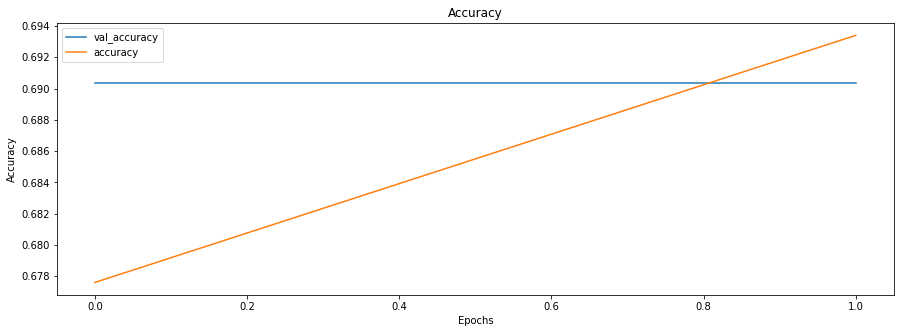

In [109]:
plt.figure(figsize=(15,5))
plt.plot(range(biomed_roberta_model_history.epoch[-1]+1), biomed_roberta_model_history.history["val_Accuracy"], label="val_accuracy")
plt.plot(range(biomed_roberta_model_history.epoch[-1]+1), biomed_roberta_model_history.history["Accuracy"], label="accuracy")
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show();

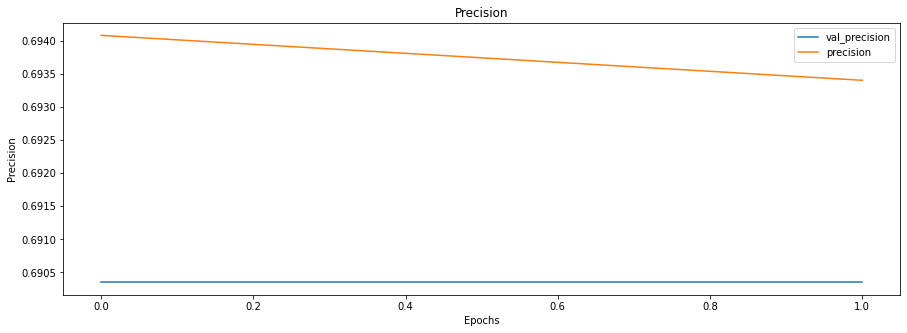

In [112]:
plt.figure(figsize=(15,5))
plt.plot(range(biomed_roberta_model_history.epoch[-1]+1), biomed_roberta_model_history.history["val_precision_3"], label="val_precision")
plt.plot(range(biomed_roberta_model_history.epoch[-1]+1), biomed_roberta_model_history.history["precision_3"], label="precision")
plt.title("Precision")
plt.ylabel("Precision")
plt.xlabel("Epochs")
plt.legend()
plt.show();

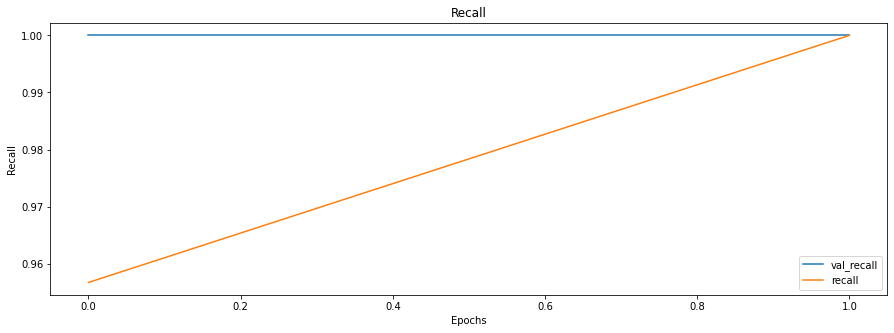

In [113]:
plt.figure(figsize=(15,5))
plt.plot(range(biomed_roberta_model_history.epoch[-1]+1), biomed_roberta_model_history.history["val_recall_3"], label="val_recall")
plt.plot(range(biomed_roberta_model_history.epoch[-1]+1), biomed_roberta_model_history.history["recall_3"], label="recall")
plt.title("Recall")
plt.ylabel("Recall")
plt.xlabel("Epochs")
plt.legend()
plt.show();

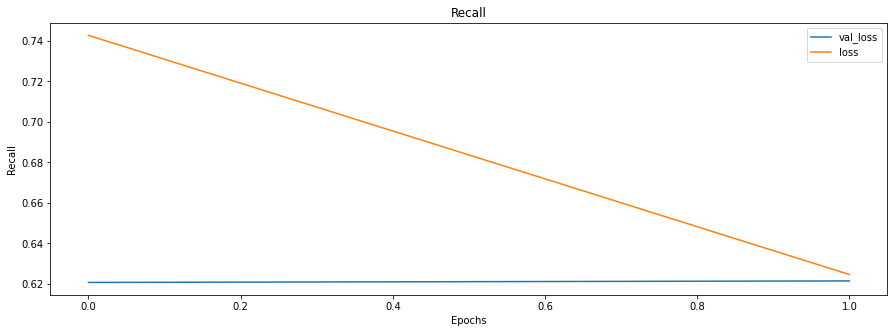

In [114]:
plt.figure(figsize=(15,5))
plt.plot(range(biomed_roberta_model_history.epoch[-1]+1), biomed_roberta_model_history.history["val_loss"], label="val_loss")
plt.plot(range(biomed_roberta_model_history.epoch[-1]+1), biomed_roberta_model_history.history["loss"], label="loss")
plt.title("Recall")
plt.ylabel("Recall")
plt.xlabel("Epochs")
plt.legend()
plt.show();